# MACHINE LEARNING MODELS

LOADING ALL LIBRARIES

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [3]:
train = pd.read_csv('/notebooks/data/train_final_v2.csv', index_col=0)
test = pd.read_csv('/notebooks/data/test_final_v2.csv', index_col = 0)

We delete some features that can't be handle with encoding

In [4]:
todrop = ['l2', 'l3', 'start_date']
train.drop(todrop, axis=1, inplace=True)
test.drop(todrop, axis=1, inplace=True)

Checking shapes, just to compare with final predictions

In [10]:
print(train.shape)
print(test.shape)

(111372, 22)
(65850, 21)


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111372 entries, 0 to 111371
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   lat             111372 non-null  float64
 1   lon             111372 non-null  float64
 2   surface_total   111372 non-null  float64
 3   property_type   111372 non-null  object 
 4   target          111372 non-null  int64  
 5   pileta          111372 non-null  int64  
 6   vigilancia      111372 non-null  int64  
 7   patio           111372 non-null  int64  
 8   garage          111372 non-null  int64  
 9   balcon          111372 non-null  int64  
 10  cancha          111372 non-null  int64  
 11  gimnasio        111372 non-null  int64  
 12  sauna           111372 non-null  int64  
 13  a_estrenar      111372 non-null  int64  
 14  bathrooms_cat   111372 non-null  int64  
 15  bedrooms_cat    111372 non-null  int64  
 16  days_published  111372 non-null  float64
 17  distance_s

### ONE HOT ENCODING FOR VARIABLES

In [5]:
ohe = OneHotEncoder(sparse=False)
to_transform = ['property_type', 'bathrooms_cat', 'bedrooms_cat']
X = ohe.fit_transform(train[to_transform])
X = pd.DataFrame(X, columns=ohe.get_feature_names_out(to_transform))
train = pd.concat([train, X], axis=1)
train.drop(to_transform, axis=1, inplace=True)

In [6]:
ohe = OneHotEncoder(sparse=False)
to_transform = ['property_type', 'bathrooms_cat', 'bedrooms_cat']
X = ohe.fit_transform(test[to_transform])
X = pd.DataFrame(X, columns=ohe.get_feature_names_out(to_transform))
test = pd.concat([test, X], axis=1)
test.drop(to_transform, axis=1, inplace=True)

### TRAIN AND TEST SUBSETS

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    train.drop('target', axis=1), train['target'], test_size=0.2,
    random_state=42, stratify=train['target'])

### CLASSIFICATION APPROACH TO DO
First we try a few common classification algorithms. We expect a lower perfomance for linear classification models like logistic regression because the dataset is unbalanced and has outliers. Probably tree based ensembled methods will perform better

For linear classification models we need to standarized our data

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


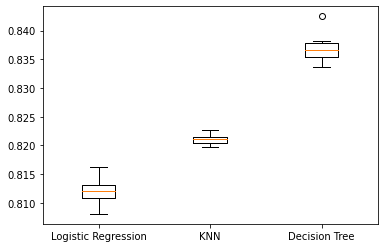

In [17]:
#Looping with cross validation the 3 models
models = {"Logistic Regression": LogisticRegression(), "KNN": KNeighborsClassifier(),
          "Decision Tree": DecisionTreeClassifier()}
results = []
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    results.append(cv_results)

#Plot with train results
plt.boxplot(results, labels=models.keys())
plt.show()

As expected, decision tree performs better. Let's move to this algorithms 

## DECISION TREE

#### DECISION TREE: GRIDSEARCH CV

In [18]:
# Create steps
steps = [("scaler", StandardScaler()), 
        ("tree", DecisionTreeClassifier(random_state=123))]

# Set up pipeline
pipeline = Pipeline(steps)
params = {"tree__max_depth": [4,8,12,14,16],
        "tree__criterion": ["gini", "entropy"],
        "tree__min_samples_leaf": [0.1, 0.5,1,2,4,6],
        "tree__max_features": ["sqrt", "log2"]
        }

# Create the GridSearchCV object
tuning = GridSearchCV(pipeline, param_grid=params, scoring='accuracy', cv=10, n_jobs=-1)
tuning.fit(X_train, y_train)
y_pred = tuning.predict(X_test)

# Compute and print performance
print("Tuned Decision Tree Classifier Parameters: {}, Acuraccy: {}, Recall: {}".format(tuning.best_params_, tuning.score(X_test, y_test), recall_score(y_test, y_pred, average='weighted')))
print("All Parameters: {}".format(tuning.get_params()))

Tuned Decision Tree Classifier Parameters: {'tree__criterion': 'gini', 'tree__max_depth': 16, 'tree__max_features': 'sqrt', 'tree__min_samples_leaf': 6}, Acuraccy: 0.849023569023569, Recall: 0.849023569023569
All Parameters: {'cv': 10, 'error_score': nan, 'estimator__memory': None, 'estimator__steps': [('scaler', StandardScaler()), ('tree', DecisionTreeClassifier(random_state=123))], 'estimator__verbose': False, 'estimator__scaler': StandardScaler(), 'estimator__tree': DecisionTreeClassifier(random_state=123), 'estimator__scaler__copy': True, 'estimator__scaler__with_mean': True, 'estimator__scaler__with_std': True, 'estimator__tree__ccp_alpha': 0.0, 'estimator__tree__class_weight': None, 'estimator__tree__criterion': 'gini', 'estimator__tree__max_depth': None, 'estimator__tree__max_features': None, 'estimator__tree__max_leaf_nodes': None, 'estimator__tree__min_impurity_decrease': 0.0, 'estimator__tree__min_samples_leaf': 1, 'estimator__tree__min_samples_split': 2, 'estimator__tree__mi

V1 DATA: Tuned Decision Tree Classifier Parameters: {'tree__criterion': 'entropy', 'tree__max_depth': 16, 'tree__max_features': 'sqrt', 'tree__min_samples_leaf': 4}, Acuraccy: 0.8323232323232324, Recall: 0.8323232323232324

V2 DATA: Tuned Decision Tree Classifier Parameters: {'tree__criterion': 'gini', 'tree__max_depth': 16, 'tree__max_features': 'sqrt', 'tree__min_samples_leaf': 6}, Acuraccy: 0.849023569023569, Recall: 0.849023569023569

#### DECISION TREE: FINAL MODEL SELECTED

In [19]:
# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=16, random_state=1, criterion='entropy', max_features='sqrt', min_samples_leaf=6)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict test set labels
y_pred = dt.predict(X_test)

dt.score(X_test, y_test)

dt.get_params()

df = pd.DataFrame({'pred': y_pred})

#### DECISION TREE: METRICS

#### ALL METRICS TOGETHER

### Confussion matrix: assessing clasification perfomance 

Accuraccy: sum of true predictions divided by total sum of the confussion matrix

Precision: VPP: number of true positives in all positive values - pacientes con prueba positiva, cuantos son verdaderos enfermos. High precision means low false positive rates. 

Recall: Sensitivity - number of true positive divided by sum of true positive and false negatives - pacientes enfermos, cuantos tienen prueba positiva.  High recall reflects a lower false negative rate. 

F1: Harmonic mean of precision and recall. Gives equal weight to precision and recall: favors models with similar metrics. 

Support: represents the number of instances for each class within the true labels.

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[15373  1324]
 [ 2102  3476]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     16697
           1       0.72      0.62      0.67      5578

    accuracy                           0.85     22275
   macro avg       0.80      0.77      0.78     22275
weighted avg       0.84      0.85      0.84     22275



#### CONFUSSION MATRIX

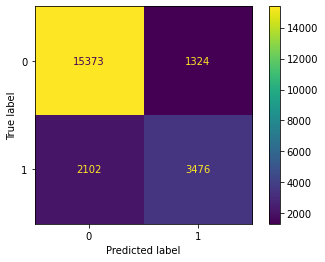

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(matrix)

cm_display.plot()

plt.show()

#### ROC AUC

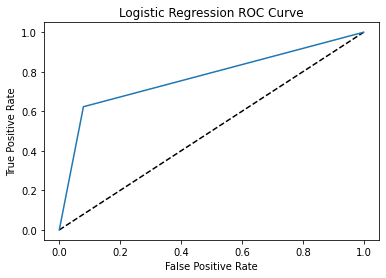

ROC under the curve is: 0.7719333709744


In [22]:
y_score = dt.predict_proba(X_test)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
print(f'ROC under the curve is: {auc}')

### FINAL PREDS TO EXPORT AND UPLOAD

In [9]:
#!cd /notebooks && mkdir predicts && cd predicts

In [23]:
# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=16, random_state=1, criterion='entropy', max_features='sqrt', min_samples_leaf=6)

# Fit dt to the training set
dt.fit(train.drop('target', axis = 1), train['target'])

# Predict test set labels
y_pred = dt.predict(test)

In [24]:
y_pred.shape

(65850,)

In [25]:
df_tree = pd.DataFrame({'pred': y_pred})
df_tree.to_csv('../notebooks/predicts/predictions_decision_tree_v3.csv', index=False)

## RANDOM FOREST

In [26]:
# Create steps
steps = [("scaler", StandardScaler()), 
        ("rfc", RandomForestClassifier(random_state=123))]

# Set up pipeline
pipeline = Pipeline(steps)
params = {'rfc__bootstrap': [True, False],
        'rfc__max_depth': [10, 20, 30, 40, 50, None],
        'rfc__min_samples_leaf': [1, 2, 4],
        'rfc__min_samples_split': [2, 5, 10],
        'rfc__n_estimators': [200, 400, 600, 800, 1000]}


# Create the GridSearchCV object
tuning = RandomizedSearchCV(pipeline, param_distributions=params, scoring='accuracy', cv=3, n_jobs=-1, n_iter=10)
tuning.fit(X_train, y_train)
y_pred = tuning.predict(X_test)

# Compute and print performance
print("Tuned Random Forest Classifier Parameters: {}, Acuraccy: {}, Recall: {}".format(tuning.best_params_, tuning.score(X_test, y_test), recall_score(y_test, y_pred, average='weighted')))
print("All Parameters: {}".format(tuning.get_params()))

/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuned Random Forest Classifier Parameters: {'rfc__n_estimators': 600, 'rfc__min_samples_split': 10, 'rfc__min_samples_leaf': 1, 'rfc__max_depth': None, 'rfc__bootstrap': False}, Acuraccy: 0.882020202020202, Recall: 0.882020202020202
All Parameters: {'cv': 3, 'error_score': nan, 'estimator__memory': None, 'estimator__steps': [('scaler', StandardScaler()), ('rfc', RandomForestClassifier(random_state=123))], 'estimator__verbose': False, 'estimator__scaler': StandardScaler(), 'estimator__rfc': RandomForestClassifier(random_state=123), 'estimator__scaler__copy': True, 'estimator__scaler__with_mean': True, 'estimator__scaler__with_std': True, 'estimator__rfc__bootstrap': True, 'estimator__rfc__ccp_alpha': 0.0, 'estimator__rfc__class_weight': None, 'estimator__rfc__criterion': 'gini', 'estimator__rfc__max_depth': None, 'estimator__rfc__max_features': 'sqrt', 'estimator__rfc__max_leaf_nodes': None, 'estimator__rfc__max_samples': None, 'estimator__rfc__min_impurity_decrease': 0.0, 'estimator__r

#### V1 DATA: Tuned Random Forest Classifier Parameters: {'rfc__n_estimators': 800, 'rfc__min_samples_split': 5, 'rfc__min_samples_leaf': 1, 'rfc__max_features': 'auto', 'rfc__max_depth': 50, 'rfc__bootstrap': False}, Acuraccy: 0.8728619528619529, Recall: 0.8728619528619529


All Parameters: {'cv': 3, 'error_score': nan, 'estimator__memory': None, 'estimator__steps': [('scaler', StandardScaler()), ('rfc', RandomForestClassifier(random_state=123))], 'estimator__verbose': False, 'estimator__scaler': StandardScaler(), 'estimator__rfc': RandomForestClassifier(random_state=123), 'estimator__scaler__copy': True, 'estimator__scaler__with_mean': True, 'estimator__scaler__with_std': True, 'estimator__rfc__bootstrap': True, 'estimator__rfc__ccp_alpha': 0.0, 'estimator__rfc__class_weight': None, 'estimator__rfc__criterion': 'gini', 'estimator__rfc__max_depth': None, 'estimator__rfc__max_features': 'sqrt', 'estimator__rfc__max_leaf_nodes': None, 'estimator__rfc__max_samples': None, 'estimator__rfc__min_impurity_decrease': 0.0, 'estimator__rfc__min_samples_leaf': 1, 'estimator__rfc__min_samples_split': 2, 'estimator__rfc__min_weight_fraction_leaf': 0.0, 'estimator__rfc__n_estimators': 100, 'estimator__rfc__n_jobs': None, 'estimator__rfc__oob_score': False, 'estimator__rfc__random_state': 123, 'estimator__rfc__verbose': 0, 'estimator__rfc__warm_start': False, 'estimator': Pipeline(steps=[('scaler', StandardScaler()),
                ('rfc', RandomForestClassifier(random_state=123))]), 'n_iter': 10, 'n_jobs': -1, 'param_distributions': {'rfc__bootstrap': [True, False], 'rfc__max_depth': [10, 20, 30, 40, 50, None], 'rfc__max_features': ['auto', 'sqrt'], 'rfc__min_samples_leaf': [1, 2, 4], 'rfc__min_samples_split': [2, 5, 10], 'rfc__n_estimators': [200, 400, 600, 800, 1000]}, 'pre_dispatch': '2*n_jobs', 'random_state': None, 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 0}

#### V2 DATA: Tuned Random Forest Classifier Parameters: {'rfc__n_estimators': 600, 'rfc__min_samples_split': 10, 'rfc__min_samples_leaf': 1, 'rfc__max_depth': None, 'rfc__bootstrap': False}, Acuraccy: 0.882020202020202, Recall: 0.882020202020202


All Parameters: {'cv': 3, 'error_score': nan, 'estimator__memory': None, 'estimator__steps': [('scaler', StandardScaler()), ('rfc', RandomForestClassifier(random_state=123))], 'estimator__verbose': False, 'estimator__scaler': StandardScaler(), 'estimator__rfc': RandomForestClassifier(random_state=123), 'estimator__scaler__copy': True, 'estimator__scaler__with_mean': True, 'estimator__scaler__with_std': True, 'estimator__rfc__bootstrap': True, 'estimator__rfc__ccp_alpha': 0.0, 'estimator__rfc__class_weight': None, 'estimator__rfc__criterion': 'gini', 'estimator__rfc__max_depth': None, 'estimator__rfc__max_features': 'sqrt', 'estimator__rfc__max_leaf_nodes': None, 'estimator__rfc__max_samples': None, 'estimator__rfc__min_impurity_decrease': 0.0, 'estimator__rfc__min_samples_leaf': 1, 'estimator__rfc__min_samples_split': 2, 'estimator__rfc__min_weight_fraction_leaf': 0.0, 'estimator__rfc__n_estimators': 100, 'estimator__rfc__n_jobs': None, 'estimator__rfc__oob_score': False, 'estimator__rfc__random_state': 123, 'estimator__rfc__verbose': 0, 'estimator__rfc__warm_start': False, 'estimator': Pipeline(steps=[('scaler', StandardScaler()),
                ('rfc', RandomForestClassifier(random_state=123))]), 'n_iter': 10, 'n_jobs': -1, 'param_distributions': {'rfc__bootstrap': [True, False], 'rfc__max_depth': [10, 20, 30, 40, 50, None], 'rfc__min_samples_leaf': [1, 2, 4], 'rfc__min_samples_split': [2, 5, 10], 'rfc__n_estimators': [200, 400, 600, 800, 1000]}, 'pre_dispatch': '2*n_jobs', 'random_state': None, 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 0}
CPU times: user 2min 5s, sys: 287 ms, total: 2min 6s
Wall time: 8min 18s

#### MODEL SELECTED with metrics

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=False,
                            max_depth=None, 
                            max_features='sqrt', 
                            min_samples_leaf=1, 
                            min_samples_split=10, 
                            n_estimators=600, 
                            random_state=123)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

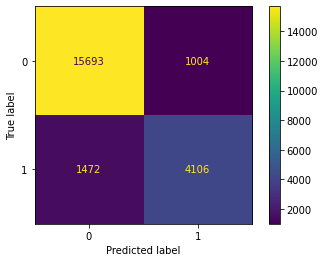

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(matrix)

cm_display.plot()

plt.show()

#### AUC-ROC

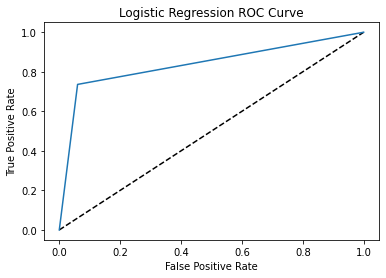

ROC under the curve is: 0.8379877844266783


In [29]:
y_score = rf.predict_proba(X_test)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
print(f'ROC under the curve is: {auc}')

#### Feature importance

In [30]:
# Print how important each column is to the model
for i, item in enumerate(rf.feature_importances_):
      # Use i and item to print out the feature importance of each column
    print("{0:s}: {1:.2f}".format(X_train.columns[i], item))

lat: 0.06
lon: 0.06
surface_total: 0.08
pileta: 0.01
vigilancia: 0.00
patio: 0.01
garage: 0.01
balcon: 0.01
cancha: 0.00
gimnasio: 0.01
sauna: 0.00
a_estrenar: 0.00
days_published: 0.03
distance_shore: 0.07
d1: 0.08
d2: 0.06
d3: 0.07
d4: 0.06
property_type_Apartamento: 0.03
property_type_Casa: 0.02
property_type_Finca: 0.00
property_type_Local comercial: 0.00
property_type_Lote: 0.01
property_type_Oficina: 0.00
property_type_Otro: 0.02
property_type_Parqueadero: 0.00
bathrooms_cat_0: 0.03
bathrooms_cat_1: 0.06
bathrooms_cat_2: 0.01
bathrooms_cat_3: 0.14
bathrooms_cat_4: 0.02
bedrooms_cat_0: 0.00
bedrooms_cat_1: 0.00
bedrooms_cat_2: 0.01
bedrooms_cat_3: 0.01
bedrooms_cat_4: 0.01


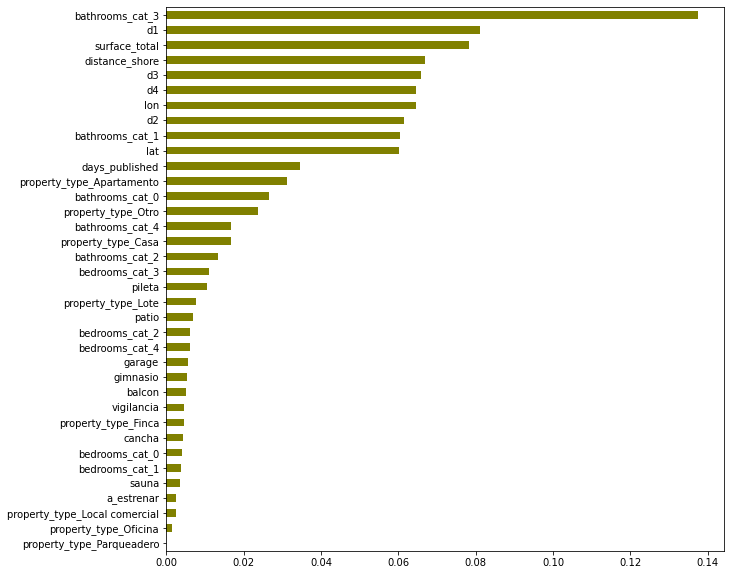

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_, index = train.drop('target', axis=1).columns)

# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()

# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='olive', figsize=(10, 10))
plt.show()

## EXPERIMENTAL RANDOM FOREST WITH LESS FEATURES based on feature importance selected by RF

In [22]:
tokeep_train = ['bathrooms_cat_3','d1','surface_total','distance_shore','target']
tokeep_test = ['bathrooms_cat_3','d1','surface_total','distance_shore']
train_less = train[tokeep_train]
test_less = test[tokeep_test]

X_train1, X_test1, y_train1, y_test1 = train_test_split(train_less.drop('target', axis=1), train_less['target'], test_size=0.2, random_state=42, stratify=train_less['target'])

In [34]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
# Create steps
steps = [("scaler", StandardScaler()), 
        ("rfc", RandomForestClassifier(random_state=123))]

# Set up pipeline
pipeline = Pipeline(steps)
params = {'rfc__bootstrap': [True, False],
        'rfc__max_depth': [10, 20, 30, 40, 50, None],
        'rfc__min_samples_leaf': [1, 2, 4],
        'rfc__min_samples_split': [2, 5, 10],
        'rfc__n_estimators': [200, 400, 600, 800, 1000]}


# Create the GridSearchCV object
tuning = RandomizedSearchCV(pipeline, param_distributions=params, scoring='accuracy', cv=3, n_jobs=-1, n_iter=10)
tuning.fit(X_train1, y_train1)

y_pred1 = tuning.predict(X_test1)

# Compute and print performance
print("Tuned Random Forest Classifier Parameters: {}, Acuraccy: {}, Recall: {}".format(tuning.best_params_, tuning.score(X_test1, y_test1), recall_score(y_test1, y_pred1, average='weighted')))
print("All Parameters: {}".format(tuning.get_params()))

/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


NameError: name 'y_pred1' is not defined

### Tuned Random Forest Classifier Parameters: {'rfc__n_estimators': 200, 'rfc__min_samples_split': 5, 'rfc__min_samples_leaf': 1, 'rfc__max_depth': 50, 'rfc__bootstrap': True}, Acuraccy: 0.847003367003367, Recall: 0.847003367003367

### MINIMALIST MODEL DIAGNOSTICS

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=True,
                            max_depth=50, 
                            max_features='sqrt', 
                            min_samples_leaf=1, 
                            min_samples_split=5, 
                            n_estimators=200, 
                            random_state=123)

rf.fit(X_train1, y_train1)

y_pred1 = rf.predict(X_test1)

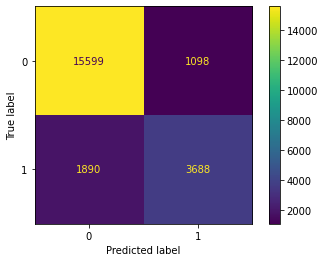

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix = confusion_matrix(y_test1, y_pred1)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.show()

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test1, y_pred1))
print(classification_report(y_test1, y_pred1))

[[15599  1098]
 [ 1890  3688]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     16697
           1       0.77      0.66      0.71      5578

    accuracy                           0.87     22275
   macro avg       0.83      0.80      0.81     22275
weighted avg       0.86      0.87      0.86     22275



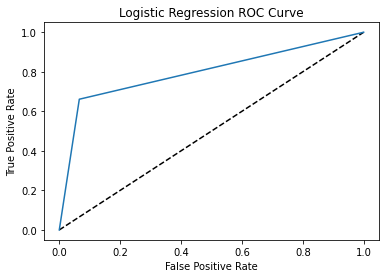

ROC under the curve is: 0.7977042807547416


In [39]:
y_score = rf.predict_proba(X_test1)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test1, y_pred1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test1, y_pred1)
print(f'ROC under the curve is: {auc}')

### FINAL MODEL TO EXPORT

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=True,
                            max_depth=50, 
                            max_features='sqrt', 
                            min_samples_leaf=1, 
                            min_samples_split=5, 
                            n_estimators=200, 
                            random_state=123)

rf.fit(train_less.drop('target', axis =1), train_less['target'])

y_pred1 = rf.predict(test_less)

In [41]:
y_pred1.shape

(65850,)

In [43]:
df_min = pd.DataFrame(y_pred1, columns=['pred'])
df_min.to_csv('predictions_random_forest_v2_minimalist.csv', index=False)

## XGBOOST

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb
import warnings
warnings.filterwarnings('ignore') 

gbm_param_grid = {'learning_rate': [0.01,0.1,0.5,0.9],
                'n_estimators': [10,20,50,100,200],
                'subsample': [0.3, 0.5, 0.9],
                'colsample_bytree_vals' : [0.1, 0.5, 0.8, 1],
                'max_depth': [2, 5, 10]
                }


gbm = xgb.XGBClassifier(objective='binary:logistic')

#grid_class = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid, scoring='accuracy', cv=3, verbose=1)
grid_class = RandomizedSearchCV(estimator=gbm,param_distributions=gbm_param_grid, scoring='accuracy', cv=5, verbose=1, n_iter=100, n_jobs=-1)

grid_class.fit(X_train, y_train)

print("Best parameters found: ",grid_class.best_params_)

print("Best accuracy found: ", grid_class.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

Best parameters found:  {'subsample': 0.3, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree_vals': 0.5}

Best accuracy found:  0.8805010269706051
Best parameters found:  {'subsample': 0.5, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree_vals': 0.8}
Best accuracy found:  0.8820386769475964

Best parameters found:  {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree_vals': 0.1}
Best accuracy found:  0.8876729621069932

In [14]:
# Split the data into training and test sets

xg_cl = xgb.XGBClassifier(objective='binary:logistic', 
                        n_estimators=200, 
                        seed=123,
                        learning_rate=0.1,
                        subsample=0.9,
                        colsample_bytree_vals=0.1,
                        max_depth=10)
                        
xg_cl.fit(X_train, y_train)

preds_xgb = xg_cl.predict(X_test)

[11:43:27] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




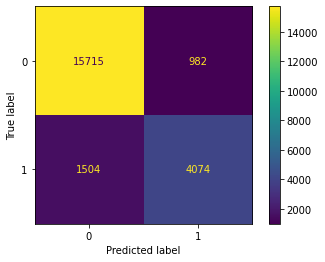

[[15715   982]
 [ 1504  4074]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.93     16697
           1       0.81      0.73      0.77      5578

    accuracy                           0.89     22275
   macro avg       0.86      0.84      0.85     22275
weighted avg       0.89      0.89      0.89     22275



In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix = confusion_matrix(y_test, preds_xgb)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.show()

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, preds_xgb))
print(classification_report(y_test, preds_xgb))

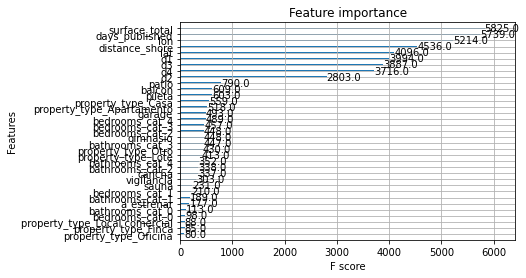

In [20]:
# Plot the feature importances
xgb.plot_importance(xg_cl)
plt.show()

#### XGBoost with feature selection approach

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb
import warnings
warnings.filterwarnings('ignore') 

gbm_param_grid = {'learning_rate': [0.01,0.1,0.5,0.9],
                'n_estimators': [10,20,50,100,200],
                'subsample': [0.3, 0.5, 0.9],
                'colsample_bytree_vals' : [0.1, 0.5, 0.8, 1],
                'max_depth': [2, 5, 10]
                }


gbm = xgb.XGBClassifier(objective='binary:logistic')

#grid_class = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid, scoring='accuracy', cv=3, verbose=1)
grid_class = RandomizedSearchCV(estimator=gbm,param_distributions=gbm_param_grid, scoring='accuracy', cv=5, verbose=1, n_iter=100, n_jobs=-1)

grid_class.fit(X_train1, y_train1)

print("Best parameters found: ",grid_class.best_params_)

print("Best accuracy found: ", grid_class.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[11:48:15] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:48:17] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:48:20] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but

[11:51:36] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:51:37] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:51:37] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some p

Best parameters found:  {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.5, 'colsample_bytree_vals': 1}
Best accuracy found:  0.8619032805812834

In [26]:
# Split the data into training and test sets

xg_cl_min = xgb.XGBClassifier(objective='binary:logistic', 
                        n_estimators=200, 
                        seed=123,
                        learning_rate=0.5,
                        subsample=0.9,
                        colsample_bytree_vals=1,
                        max_depth=10)
                        
xg_cl_min.fit(X_train1, y_train1)

preds_xgb_min = xg_cl_min.predict(X_test1)

[11:58:38] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




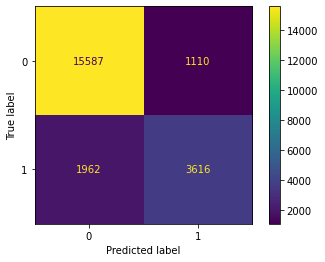

[[15587  1110]
 [ 1962  3616]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     16697
           1       0.77      0.65      0.70      5578

    accuracy                           0.86     22275
   macro avg       0.83      0.79      0.81     22275
weighted avg       0.86      0.86      0.86     22275



In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix = confusion_matrix(y_test1, preds_xgb_min)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.show()

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test1, preds_xgb_min))
print(classification_report(y_test1, preds_xgb_min))

In [28]:
# Split the data into training and test sets

xg_cl_2 = xgb.XGBClassifier(objective='binary:logistic', 
                        n_estimators=200, 
                        seed=123,
                        learning_rate=0.1,
                        subsample=0.9,
                        colsample_bytree_vals=0.1,
                        max_depth=10)
                        
xg_cl_2.fit(train_less.drop('target', axis=1), train_less['target'])

preds_xgb_2 = xg_cl_2.predict(test_less)

[12:25:16] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree_vals" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [29]:
df = pd.DataFrame(preds_xgb_2, columns=['pred'])
df.to_csv('../notebooks/predicts/predictions_xgboost_v1_minimalist.csv', index=False)

## Graphics comparing metrics for each model selected